 # Machine Learning LAB 1 (course 2020/21, P. Zanuttigh, M. Toldo) 

The notebook contains some simple tasks to be performed about classification and regression. Complete all the required code sections and answer to all the questions.

## 1) Classification of NBA players role

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!

### Place your name and ID number. Also recall to save the file as Surname_Name_LAB1.ipynb

Student name: Lorenzo Saccaro <br> 
ID Number: 1123705

### Dataset description

We will be working with a dataset of NBA basketball players data (you can get from https://www.kaggle.com/jacobbaruch/nba-player-of-the-week the full dataset).

The provided data is a subset of the Kaggle dataset containing the players that have the role of Center and of Point Guard. For each player the dataset contains 3 features, the height, the weight and the age.

From Wikipedia (if you are not a basketball fan!!):

The Center (C), also known as the five, or the big man, is one of the five positions in a regular basketball game. The center is normally the tallest player on the team, and often has a great deal of strength and body mass as well. In the NBA, the center is usually 6' 10" (2.08 m) or taller and usually weighs 240 lbs (109 kg) or more. 

Point Guards (PG, a.k.a. as "play maker") are expected to run the team's offense by controlling the ball and making sure that it gets to the right players at the right time. In the NBA, point guards are usually about 6' 3" (1.93 m) or shorter, and average about 6' 2" (1.88 m). Having above-average size (height, muscle) is considered advantageous, although size is secondary to situational awareness, speed, quickness, and ball handling skills. Shorter players tend to be better dribblers since they are closer to the floor, and thus have better control of the ball while dribbling. 


As it is clear from the description, the height and weight of the player are good hints to predict their role and in this lab we will exploit this features to estimate the role.


### Three features are considered for this dataset:


1) Height in cm

2) Weight in kg

3) Age in years

We first import all the packages that are needed.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv

import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

# Perceptron
Firstly we will implement the perceptron algorithm and use it to learn a halfspace.

**TO DO** Set the random seed (you can use your ID (matricola) or any other number!).

In [2]:
IDnumber = 1123705 #YOUR_ID , try also to change the seed to see the impact of random initialization on the results
np.random.seed(IDnumber)

Load the dataset and then split in training set and test set (the training set is typically larger, you can use a 70% tranining 30% test split) after applying a random permutation to the datset.

A) Load dataset and perform permutation

In [3]:
#load the dataset
filename = 'data/NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA) #skip first line
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:4] #columns 1,2,3 contain the features
Y = dataset[:,0]  # column 0: labels

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0]
print(m)
permutation = np.random.permutation(m) # random permurtation

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']
260


We are going to classify class "1" (Center) vs class "-1" (Point Guard)

B) **TO DO** Divide the data into training set and test set (70% of the data in the first set, 30% in the second one)

In [4]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.

#m_training needs to be the number of samples in the training set
m_training = int(260*0.7)# PLACE YOUR CODE

#m_test needs to be the number of samples in the test set
m_test = m-m_training # PLACE YOUR CODE

#X_training = instances for training set
X_training = X[:m_training,:] # PLACE YOUR CODE
#Y_training = labels for the training set
Y_training = Y[:m_training]# PLACE YOUR CODE

#X_test = instances for test set
X_test =X[m_training:,:] # PLACE YOUR CODE
#Y_test = labels for the test set
Y_test = Y[m_training:]# PLACE YOUR CODE

print(Y_training) #to make sure that Y_training contains both 1 and -1
print("number of 1:",np.count_nonzero(Y_training==1), "number of -1: ", np.count_nonzero(Y_training==-1))
print(m_test)

print("Shape of training set: " + str(X_training.shape))
print("Shape of test set: " + str(X_test.shape))

[-1 -1  1  1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1  1 -1 -1  1  1  1
 -1  1  1 -1 -1  1  1 -1 -1  1  1  1 -1 -1 -1  1  1 -1  1  1 -1 -1  1 -1
 -1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1 -1  1
 -1  1 -1  1  1  1  1  1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1  1  1  1  1  1
 -1 -1 -1 -1 -1 -1  1 -1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1 -1  1  1
  1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1  1  1 -1 -1 -1  1
 -1  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1  1  1 -1  1 -1  1  1 -1
 -1  1  1 -1  1  1  1  1 -1 -1 -1  1  1 -1]
number of 1: 100 number of -1:  82
78
Shape of training set: (182, 3)
Shape of test set: (78, 3)


We add a 1 in front of each sample so that we can use a vector in homogeneous coordinates to describe all the coefficients of the model. This can be done with the function $hstack$ in $numpy$.

In [5]:
#add a 1 to each sample (homogeneous coordinates)
X_training = np.hstack((np.ones((m_training,1)),X_training))
X_test = np.hstack((np.ones((m_test,1)),X_test))

**TO DO** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where one iteration corresponds to one update of the perceptron weights. In case the termination is reached because the maximum number of iterations have been completed, the implementation should return **the best model** seen up to now.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of misclassified samples for the best model

In [6]:
# A template is provided, but feel free to build a different implementation

def perceptron_update(current_w, x, y):
    # Place in this function the update rule of the perceptron algorithm
    
    new_w = current_w + y*x
    # PLACE YOUR CODE

    return new_w

def perceptron(X, Y, max_num_iterations):
    # Place in this function the main section of the perceptron algorithm
    
    #init the algorith with w=0, use a best_w variable to keep track of the best solution
    curr_w = np.zeros(shape=X_training.shape[1])# PLACE YOUR CODE
    best_w = curr_w# PLACE YOUR CODE
    num_samples = X_training.shape[0]# PLACE YOUR CODE
    best_error = num_samples # PLACE YOUR CODE
    
    index_misclassified = 0 #will be ovewritten
    num_misclassified = 0 #will be ovewritten
    
    
    #main loop continue until all samples correctly classified or max # iterations reached
    num_iter = 0
    
    while ((index_misclassified != -1) and (num_iter < max_num_iterations)):
        
        index_misclassified = -1
        num_misclassified = 0
        
        # avoid working always on the same sample, you can use a random permutation or randomize the choice of misclassified
        
        # PLACE YOUR CODE TO RANDOMIZE
        indexes_misclassified = []
        
        for i in range(num_samples):     
            
            #check if the i-th randomly selected sample is misclassified
            # store the number of randomly classified samples and the index of at least one of them
            
            if Y[i]*np.dot(X[i],curr_w)<=0:
                num_misclassified+=1
                indexes_misclassified.append(i)
                      
        
        
        if num_misclassified<best_error:
            best_error=num_misclassified
            best_w=curr_w  
        
        
        #update  error count, keep track of best solution
        #here I take a random misclassified sample to use for updating the perceptron
        index_misclassified=np.random.choice(indexes_misclassified)
        
        # PLACE YOUR CODE
    
        num_iter += 1
        curr_w = perceptron_update(curr_w,X[index_misclassified],Y[index_misclassified])
        
        
        #call update function using a misclassifed sample
    
    
    best_error /= num_samples # PLACE YOUR CODE
    
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 100 iterations and print the error of the best model we have found.

In [7]:
#now run the perceptron for 100 iterations
w_found, error = perceptron(X_training,Y_training, 100)
print("Training Error of perpceptron (100 iterations): " + str(error))

Training Error of perpceptron (100 iterations): 0.08241758241758242


**TO DO** use the best model $w\_found$ to predict the labels for the test dataset and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [8]:
#now use the w_found to make predictions on test dataset

num_errors = 0

# PLACE YOUR CODE to compute the number of errors
for i in range(m_test):
    if  Y_test[i]*np.dot(X_test[i],w_found)<=0:
        num_errors+=1
    

true_loss_estimate = num_errors/m_test  # error rate on the test set
#NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perpceptron (100 iterations): " + str(true_loss_estimate))

Test Error of perpceptron (100 iterations): 0.08974358974358974


**TO DO** **[Answer the following]** What about the difference betweeen the training error and the test error  in terms of fraction of misclassified samples)? Explain what you observe. [Write the answer in this cell]

**ANSWER QUESTION 1**

The training error is slightly lower than the test error: this is generally expected and it also shows that the training/test sets are representative of the dataset (not an "unlucky" split).

**TO DO** Copy the code from the last 2 cells above in the cell below and repeat the training with 3000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [9]:
#now run the perceptron for 3000 iterations here!

# PLACE YOUR CODE
w_found, error = perceptron(X_training,Y_training, 3000)
print("Training Error of perpceptron (3000 iterations): " + str(error))

num_errors = 0

# PLACE YOUR CODE to compute the number of errors
for i in range(m_test):
    if  Y_test[i]*np.dot(X_test[i],w_found)<=0:
        num_errors+=1
    

true_loss_estimate = num_errors/m_test  # error rate on the test set

print("Test Error of perpceptron (3000 iterations): " + str(true_loss_estimate))

Training Error of perpceptron (3000 iterations): 0.07142857142857142
Test Error of perpceptron (3000 iterations): 0.08974358974358974


**TO DO** [Answer the following] What about the difference betweeen the training error and the test error  in terms of fraction of misclassified samples) when running for a larger number of iterations ? Explain what you observe and compare with the previous case. [Write the answer in this cell]

**ANSWER QUESTION 2**

Increasing the number of iterations the training error drops a bit to around 7% while the test error stays the same. This means that the improved model produces the same results on the test set. As expected, changing the seed produces different results.

# Logistic Regression
Now we use logistic regression, exploiting the implementation in Scikit-learn, to predict labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [10]:
filename = 'data/NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA)
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:]
Y = dataset[:,0]

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m)

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']


**TO DO** As for the previous part, divide the data into training and test (70%-30%) and add a 1 as first component to each sample.

In [11]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.

m_training = int(260*0.7)# PLACE YOUR CODE
m_test = m-m_training # PLACE YOUR CODE

#X_training = instances for training set
X_training = X[:m_training,:] # PLACE YOUR CODE
#Y_training = labels for the training set
Y_training = Y[:m_training]# PLACE YOUR CODE

#X_test = instances for test set
X_test =X[m_training:,:] # PLACE YOUR CODE
#Y_test = labels for the test set
Y_test = Y[m_training:]# PLACE YOUR CODE

print(Y_training) #to make sure that Y_training contains both 1 and -1
print("number of 1:",np.count_nonzero(Y_training==1), "number of -1: ", np.count_nonzero(Y_training==-1))
print(m_test)

print("Shape of training set: " + str(X_training.shape))
print("Shape of test set: " + str(X_test.shape))


[ 1 -1  1 -1  1  1  1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1 -1  1  1 -1
 -1 -1  1 -1 -1  1 -1  1  1  1 -1  1 -1 -1  1  1  1  1 -1 -1  1  1 -1  1
  1  1 -1  1  1  1 -1 -1 -1  1  1 -1  1  1  1  1 -1 -1 -1  1  1 -1  1  1
  1 -1 -1  1  1 -1  1 -1  1  1 -1 -1 -1  1  1  1 -1 -1  1 -1 -1  1 -1  1
 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1
 -1 -1  1  1 -1 -1  1 -1  1  1 -1  1 -1  1  1  1 -1  1 -1  1 -1 -1 -1  1
 -1  1  1  1  1 -1  1 -1  1  1  1 -1 -1  1  1  1 -1  1 -1  1  1  1 -1  1
 -1  1  1 -1 -1  1  1  1  1 -1 -1 -1  1 -1]
number of 1: 104 number of -1:  78
78
Shape of training set: (182, 3)
Shape of test set: (78, 3)


To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it.

**TO DO** Define the logistic regression model, then learn the model using the training set and predict on the test set. Then print the fraction of samples misclassified in the training set and in the test set.

In [12]:
#part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5) #a large C disables regularization

#learn from training set

logreg.fit(X_training,Y_training)

# PLACE YOUR CODE

#predict on training set

predict = logreg.predict(X_training)
# PLACE YOUR CODE

#print the error rate = fraction of misclassified samples

error_rate_training = 1-np.count_nonzero(predict==Y_training)/m_training

# PLACE YOUR CODE

print("Error rate on training set: "+str(error_rate_training))

#predict on test set

predict = logreg.predict(X_test)

# PLACE YOUR CODE

#print the error rate = fraction of misclassified samples
error_rate_test = 1-np.count_nonzero(predict==Y_test)/m_test

# PLACE YOUR CODE

print("Error rate on test set: " + str(error_rate_test))

Error rate on training set: 0.05494505494505497
Error rate on test set: 0.07692307692307687


**TO DO** Now pick two features and restrict the dataset to include only two features, whose indices are specified in the $feature$ vector below. Then split into training and test. Which features are you going to select ?

In [13]:
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['height', 'weight', 'age']
labels_list = ['Center', 'Point guard']

# select a pair of features
index_feature1 = 0 # we choose height
index_feature2 = 1 # and weight (age of course is not very meaningful)
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X_reduced = X[:,features]

X_training = X_reduced[:m_training,:]# PLACE YOUR CODE
Y_training = Y[:m_training]# PLACE YOUR CODE

X_test = X_reduced[m_training:,:]# PLACE YOUR CODE
Y_test = Y[m_training:]# PLACE YOUR CODE

Now learn a model using the training data and measure the performances.

In [14]:
logreg = linear_model.LogisticRegression(C=1e5) #a large C disables regularization

#learn from training set

logreg.fit(X_training,Y_training)

# PLACE YOUR CODE

#predict on training set

predict = logreg.predict(X_training)
# PLACE YOUR CODE

#print the error rate = fraction of misclassified samples

error_rate_training = 1-np.count_nonzero(predict==Y_training)/m_training

# PLACE YOUR CODE

print("Error rate on training set: "+str(error_rate_training))

#predict on test set

predict = logreg.predict(X_test)

# PLACE YOUR CODE

#print the error rate = fraction of misclassified samples
error_rate_test = 1-np.count_nonzero(predict==Y_test)/m_test

# PLACE YOUR CODE

print("Error rate on test set: " + str(error_rate_test))


Error rate on training set: 0.05494505494505497
Error rate on test set: 0.07692307692307687


**TO DO** [Answer the following] Which features did you select and why ? Compare the perfromances with the ones of the case with all the 3 features and comment about the results. [Write the answer in this cell]

**ANSWER QUESTION 3**

Weight and height are definitely more meaningful for determining the role of a player: age can be used to predict other stats like MPG (minutes per game). Although, there are no differences (at least for my seed) between the model using all the three features and the model restricted to these two features.  The error rates for training and test set are the same in the two cases, with the training error that is slightly less than the test error. This may mean that in this particular split between training and test data the age feature doesn't affect the outcome (i.e. no outliers caused by age)



If everything is ok, the code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

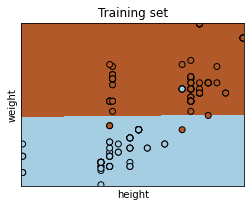

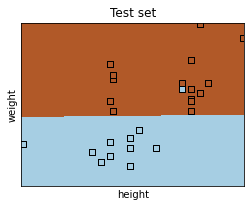

In [15]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

# NOTICE: This visualization code has been developed for a "standard" solution of the notebook, 
# it could be necessary to make some fixes to adapt to your implementation

h = .02  # step size in the mesh
x_min, x_max = X_reduced[:, 0].min() - .5, X_reduced[:, 0].max() + .5
y_min, y_max = X_reduced[:, 1].min() - .5, X_reduced[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_training[:, 0], X_training[:, 1], c=Y_training, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Training set')

plt.show()

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Test set')

plt.show()

# 2) Linear Regression on the Boston House Price dataset

Dataset description: <br>
The Boston House Price Dataset involves the prediction of a house price in thousands of dollars given details about the house and its neighborhood.

The dataset contains a total of 500 observations, which relate 13 input features to an output variable (house price).

The variable names are as follows:

CRIM: per capita crime rate by town.

ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS: proportion of nonretail business acres per town.

CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

NOX: nitric oxides concentration (parts per 10 million).

RM: average number of rooms per dwelling.

AGE: proportion of owner-occupied units built prior to 1940.

DIS: weighted distances to five Boston employment centers.

RAD: index of accessibility to radial highways.

TAX: full-value property-tax rate per $10,000.

PTRATIO: pupil-teacher ratio by town.

B: 1000*(Bk – 0.63)2 where Bk is the proportion of blacks by town.

LSTAT: % lower status of the population.

MEDV: Median value of owner-occupied homes in $1000s.
    

In [16]:
#needed if you get the IPython/javascript error on the in-line plots
%matplotlib nbagg  

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats

In [17]:
#Import Data: Load the data from a .csv file

filename = "data/house.csv"
Data = np.genfromtxt(filename, delimiter=';',skip_header=1)

#A quick overview of data, to inspect the data you can use the method describe()


# dataDescription = stats.describe(Data)
# print(dataDescription)
print ("Shape of data array: " + str(Data.shape))


#for more interesting visualization: use Panda!
pd.DataFrame(Data).describe()

Shape of data array: (500, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,3.655786,11.500000,11.131740,0.070000,0.554451,6.282970,68.424600,3.811932,9.642000,409.624000,18.428600,356.208040,12.698740,225.680000
std,8.644375,23.428739,6.900712,0.255403,0.116550,0.705421,28.272145,2.112591,8.715604,168.998579,2.162553,91.741874,7.164928,92.357075
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,50.000000
25%,0.082598,0.000000,5.130000,0.000000,0.448750,5.883000,44.225000,2.087875,4.000000,281.000000,17.225000,375.085000,6.990000,170.750000
50%,0.266005,0.000000,9.125000,0.000000,0.538000,6.208500,77.150000,3.267450,5.000000,330.000000,19.000000,391.305000,11.430000,212.000000
75%,3.694070,12.500000,18.100000,0.000000,0.624000,6.620500,94.100000,5.214600,24.000000,666.000000,20.200000,396.157500,17.092500,250.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,500.000000


# Split data in training, validation and test sets



Given $m$ total data, denote with $m_{tv}$ the part used for training and validation. Keep $m_t$ data as training data, $m_{val}:=m_{tv}-m_t$ as validation data and $m_{test}:=m - m_{val} - m_t = m-m_{tv}$. For instance one can take $m_t=0.6m$ of the data as training, $m_{val}=0.2m$  validation and $m_{test}=0.2m$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{val}$ the validation data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

VALIDATION DATA: When different model classes are present (e.g. of different complexity such as linear regression which uses a different number $d_j$ of regressors $x_1$,...$x_{d_j}$), one has to choose which one is the "best" complexity. In this simple example the validation set is not needed, but it is better to get used with it.
Let ${\cal H}_{d_j}$ be the space of models as a function of the complexity $d_j$ and let 
$$
\hat h_{d_j} = {\rm arg\; min}_{h \in {\cal H}_{d_j}} \, L_S(h)
$$

One can estimate the generalization error for model $\hat h_{d_j}$ as follows:
$$
L_{{\cal D}}(\hat h_{d_j}) \simeq \frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$
and then choose the complexity which achieves the best estimate of the generalization error
$$
\hat d_j: = {\rm arg\; min}_{d_j} \,\frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$

TESTING DATA: Last, the test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$


**TO DO**: split the data in training, validation and test sets (60%-20%-20%)

In [18]:
#get number of total samples
num_total_samples = Data.shape[0]

print ("Total number of samples: ", num_total_samples)

#size of each chunk of data (1/4 each): 2 of them for training, 1 for validation, 1 for testing
size_chunk = num_total_samples//5 # PLACE YOUR CODE

print ("Size of each chunk of data: ", size_chunk)

#shuffle the data
np.random.shuffle(Data)

#training data 

X_training = Data[:3*size_chunk,:-1]# PLACE YOUR CODE
Y_training = Data[:3*size_chunk,-1]# PLACE YOUR CODE
print ("Training input data size: ", X_training.shape)
print ("Training output data size: ", Y_training.shape)

#validation data, to be used to choose among different models
X_validation = Data[3*size_chunk:4*size_chunk,:-1]# PLACE YOUR CODE
Y_validation = Data[3*size_chunk:4*size_chunk,-1]# PLACE YOUR CODE
print ("Validation input data size: ", X_validation.shape)
print ("Validation output data size: ", Y_validation.shape)

#test data, to be used to estimate the true loss of the final model(s)
X_test = Data[4*size_chunk:,:-1]# PLACE YOUR CODE
Y_test = Data[4*size_chunk:,-1]# PLACE YOUR CODE
print ("Test input data size: ", X_test.shape)
print ("Test output data size: ", Y_test.shape)

Total number of samples:  500
Size of each chunk of data:  100
Training input data size:  (300, 13)
Training output data size:  (300,)
Validation input data size:  (100, 13)
Validation output data size:  (100,)
Test input data size:  (100, 13)
Test output data size:  (100,)


# Data Normalization
It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to 1. This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients.

In [19]:
#scale the data

# standardize the input matrix
from sklearn import preprocessing
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

X_training = scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_validation = scaler.transform(X_validation) # use the same transformation on validation data
print ("Mean of the validation input data:", X_validation.mean(axis=0))
print ("Std of the validation input data:", X_validation.std(axis=0))

X_test = scaler.transform(X_test) # use the same transformation on test data
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Mean of the training input data: [ 2.86807615e-16  1.35447209e-16  3.85432427e-15 -4.44089210e-18
 -5.08482145e-16  7.77748236e-15 -3.91538653e-16 -3.80436423e-16
 -4.14483263e-17  1.11762451e-16  1.90777024e-14  2.13014791e-15
  1.05693232e-15]
Std of the training input data: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean of the validation input data: [-0.05777393 -0.13410761  0.02283996  0.0421076  -0.0017394  -0.11560574
 -0.03743153 -0.04623537 -0.1151486  -0.17075008 -0.02917736  0.22327729
  0.05069572]
Std of the validation input data: [1.12258297 0.81642328 0.89014582 1.07436275 1.03193852 0.97740961
 0.98767565 0.84483439 0.93976682 0.94999874 0.96249524 0.53701727
 0.92033615]
Mean of the test input data: [ 0.05959098 -0.10046103  0.03164946  0.16843038 -0.02320434 -0.13823891
 -0.00568095 -0.03819065 -0.07563683 -0.05235868  0.21342427  0.12915388
  0.09769093]
Std of the test input data: [1.45357293 0.96332234 0.95530295 1.26322788 0.96312607 0.96240281
 0.93184363 0.9690970

# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-$th row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$.


 **TO DO:** compute the linear regression coefficients using np.linalg.lstsq from scikitlear 
 

In [20]:
#compute linear regression coefficients for training data


#add a 1 at the beginning of each sample for training, validation, and testing (use homogeneous coordinates)
m_training = X_training.shape[0]
X_trainingH = np.hstack((np.ones((m_training,1)),X_training)) # H: in homogeneous coordinates
#print X_training[0,:]

m_validation = X_validation.shape[0]
X_validationH = np.hstack((np.ones((m_validation,1)),X_validation))  # H: in homogeneous coordinates
#print X_validation[0,:]

m_test = X_test.shape[0]
X_testH = np.hstack((np.ones((m_test,1)),X_test))  # H: in homogeneous coordinates
#print X_test[0,:]   

# Compute the least-squares coefficients using linalg.lstsq
w_np, RSStr_np, rank_Xtr, sv_Xtr =  np.linalg.lstsq(X_trainingH,Y_training,rcond=None)# PLACE YOUR CODE
print("LS coefficients with numpy lstsq:", w_np)

# compute Residual sums of squares 

RSStr_hand = np.linalg.norm(Y_training-np.dot(X_trainingH,w_np))**2

print("RSS by hand: ", RSStr_hand)
print("RSS with numpy lstsq: ", RSStr_np)
print("Empirical risk with numpy lstsq:", RSStr_np/m_training)

LS coefficients with numpy lstsq: [228.36        -6.37452989  17.0473055    3.74197343   8.1733601
 -25.88768447  25.30569742   4.31039092 -38.29385912  25.71583325
 -19.653707   -18.30752579  10.64142776 -43.31824023]
RSS by hand:  737997.5567479116
RSS with numpy lstsq:  [737997.55674791]
Empirical risk with numpy lstsq: [2459.99185583]


## Data prediction 

Compute the output predictions on both training and validation set and compute the Residual Sum of Sqaures (RSS). 

**TO DO**: Compute these quantities on  training, validation and test sets.

In [21]:
#compute predictions on training and validation

#prediction_training 
prediction_training = np.dot(X_trainingH,w_np)# PLACE YOUR CODE
prediction_validation = np.dot(X_validationH,w_np)# PLACE YOUR CODE
prediction_test = np.dot(X_testH,w_np)# PLACE YOUR CODE

#what about the loss for points in the validation data?
RSS_validation = np.linalg.norm(Y_validation-prediction_validation)**2# PLACE YOUR CODE
RSS_test = np.linalg.norm(Y_test-prediction_test)**2# PLACE YOUR CODE

print("RSS on validation data:",  RSS_validation)
print("Loss estimated from validation data:", RSS_validation/m_validation)

print("RSS on test data:",  RSS_test)
print("Loss estimated from test data:", RSS_test/m_test)

RSS on validation data: 159014.03730928974
Loss estimated from validation data: 1590.1403730928973
RSS on test data: 214310.08853341508
Loss estimated from test data: 2143.100885334151


### QUESTION 4: Comment on the results you get and on the difference between the train, validation and test errors.

Both losses estimated from the test and validation data are lower than the training set (for this particular shuffle of the dataset).
Shuffling multiple times (or changing the seed) alters the outcome and the training loss result lower than the other two. In this case, the value of the validation loss is not meaningful because we are not trying different hypothesis classes (other than the linear model). It can be seen as another indicator of model performance (like another test set) since we did not use it to choose among different hypotheses. 


## Ordinary Least-Squares using scikit-learn
Another fast way to compute the LS estimate is through sklearn.linear_model (for this function homogeneous coordinates are not needed).

In [22]:
from sklearn import linear_model

# build the LinearRegression() model and train it
LinReg = linear_model.LinearRegression().fit(X_training,Y_training)# PLACE YOUR CODE


# PLACE YOUR CODE

print("Intercept:", LinReg.intercept_)
print("Least-Squares Coefficients:", LinReg.coef_)

# predict output values on training and test sets
prediction_training = LinReg.predict(X_training)
prediction_test = LinReg.predict(X_test)
print("RSS on training data:", np.linalg.norm(Y_training-prediction_training)**2)
print("RSS on test data:", np.linalg.norm(Y_test-prediction_test)**2)
# PLACE YOUR CODE

# return a prediction score based on the coefficient of determination
print("Measure on training data:", 1-LinReg.score(X_training, Y_training))

Intercept: 228.36000000000016
Least-Squares Coefficients: [ -6.37452989  17.0473055    3.74197343   8.1733601  -25.88768447
  25.30569742   4.31039092 -38.29385912  25.71583325 -19.653707
 -18.30752579  10.64142776 -43.31824023]
RSS on training data: 737997.5567479118
RSS on test data: 214310.08853341523
Measure on training data: 0.2592981448990066
